<a href="https://colab.research.google.com/github/Enoch64/Image-Classification-with-sci-kit-Learn-/blob/main/Image_Classification_with_sci_kit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys 
assert sys.version_info >= (3, 7)



In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
#Defining the font sizes to make the figures more clear 
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
#Creating an image classification folder to save figures in high resoltuion 
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
#import the MNIST data set from sklearn module 
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame = False)


In [6]:

mnist.keys()
#The dictionary structure of the data
#A DESCR key describing the dataset
#A a data key containing an array with one row per instance and one column per feature 


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
X, y = mnist["data"], mnist["target"]

In [8]:
X.shape

(70000, 784)

In [9]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features.This is because each image is a 28x28 pixel and each feautre represents one pixel's intensity from 0 to 255. Let's look at one digit from the data set. By grabbing an instance's feature vector and reshaping it to a 28x28 array we can display it with matplotlibs imshow() function



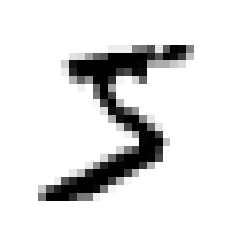

In [10]:
#Using matplot lib to graph a hand written digit 
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis('off')
plt.show()


In [11]:
y[0]


'5'

The above digit is indeed 5. Note that the label is a string so we do an simply integer conversion



In [12]:
import numpy as np
y = y.astype(np.uint8)


We now need to create a test set before inspecting the data closely. The MNIST data set is already split into a training set(first 60,000 images) and test set(the last 10,000 images)


In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


##**Training a Binary Classifier**

Let's simplify the problem for now to idnetify a singel digit e.g 5. This "5 detector" will be an example of a binary classifier, capable of distinguishing between just two classes i.e. "5" and "not 5" 

In [14]:
#Creating a target vectors for this classification task 
y_train_5 = (y_train == 5) #True for all 5s false for all other digits 
y_test_5 = (y_test ==5)

A good classifier to chose would be *Stochastic Gradient Decent*(SGD) using Scikit-Learn's SGD Classifier class. This classifier has the capabilities to handle very large data sets effeciently. This is partly because the SGD deals with training instances independently one at a time. 


In [15]:
#Let's create an SGDC classifier and train it on the whole training set 
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf = sgd_clf.fit(X_train, y_train_5)

In [16]:
sgd_clf.predict([some_digit])



array([ True])

This classifier guesses this image represents a 5(True). Looks like it guessed right in this particular case. Now let's evaluate the performance of Stochastic Gradient Decent 

##**Measuring accuracy with Cross Validation**

In [17]:
#Implementing Cross Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone 
skfolds = StratifiedKFold(n_splits=3, random_state=None)


for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]
  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.96495


0.95035
0.96035
0.9604


The StratifiedKFold class perofrms stratified sampling to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds and makes prediction on the test folds. Then it counts the number of correct predictions and outputs the ratio of correct prediction 

In [18]:
#Let's use the cross_val_score() function to evaluate our SGD Classifier model using K-fold cross validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

The model has an accuracy of over 90% accuracy because about 10% of the images are 5s. So if you guess that an immage is not 5 you will be right 90% of the time!This demonstrates why accuracy is not the preferred performance for classifiers especially when dealing with skewed data sets(i.e when some classes are more frequent than others


##**Confusion Matrix**

A much better way to evaluate to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of instances in class A are classified as class B. In our case we'd count the number of times the classifier confused images of 5s with 3s, you would look at the 5th row and 3rd column of the confusion matrix 

To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to actual targets. You could make predictions on the test set but we usually want to use the test send at the very end of the project

In [19]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


Just like the cross_val_score() function, cross_val_predict() perform K-fold cross validation, but instead of returning evaluation scores, it returns predictions made on each test fold 

In [20]:
#Getting the confusion matrix with the predictions made on the test folds 
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)


array([[53892,   687],
       [ 1891,  3530]])

Each row in the confusion matrix represents *actual class*, while each column represents the *predicted class*. 

The first row of the matrix considers non-5 images(negative class). 53,892 images were correctly classified as non-5s while the remaining 687 were wrongly classfied as 5s. The second row considers the images of 5s(positive class). 1891 were wrongly classified as non-5s(false negatives) while the remaining 3530 were classified correctly as 5s(true positives)

There are various strategies that you can use to perform multiclass classification using multiple binary classifiers. For example, one way to create a system that can classify the digital images into 10 classes(from 0 to 9) is to train 10 binary classifiers 

Another strategy is to train a binary classifier or ever pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s and so on. This is called the *the one versus one*(OvO) strategy. If there are N classes, you need to train N x (N-1)/2 classifiers. In particular for the MNIST data set this means training 45 binary classes. 

Some algorithms(such as Support Vector Machine classifiers) scale poorly with the training set, so for these algorithms OvO is preferred since its faster to train many classifiers on small training sets than training few classifiers on large training sets.

Scikit learn detects when you are trying to use a binary classfication algorithm for a multi-class classification task and it automatically runs OvA. One versus All(OvA) is a heurestic method for using binary classification algorithm for multi-class algorithms. 

In [21]:
#Multi-class classification with Stochastic Gradient Descent(SGD)
sgd_clf.fit(X_train, y_train) 
#Let's predict what X[2] will be 
sgd_clf.predict([X[2]])


array([4], dtype=uint8)

In [22]:
y[2]

4

As seen above the model correctly classified the number 4 

In [23]:
#Error analysis for the mutliclass SGD Classifier
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")


array([0.87365, 0.85835, 0.8689 ])

It gets over 84% accuracy on all test folds however this can be imporved by scaling the inputs

In [24]:
#Scaling inputs to increase accuracy with StandardScaler from scikit learn 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


array([0.8983, 0.891 , 0.9018])

In [ ]:
#Confusion Matrix for the SGD multi-class classifier
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3 )
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx



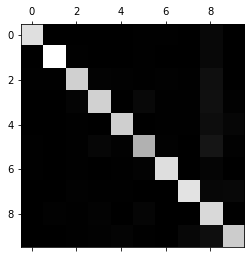

In [26]:
#Visiualizing the confusion matrix with matplot lib
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()



In [ ]:
#Mutli-class classification with Random Forest Classfier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3, method="predict_proba")
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])





In [28]:
#Using predict_proba() to get the list of probabilites that the classifier assigned to each class
forest_clf.predict_proba([some_digit])


array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

As seen the classifier is fairly confident about its predcition: the 0.9 at the 5th index in the array means that the mode estimated a 90% probability of the image representing 5 

In [ ]:
#Confusion matrix for the RandomForestClassifier
y_train_pred = cross_val_predict(forest_clf,X_train, y_train, cv=3)
cnf_mx_2 = confusion_matrix(y_train,y_train_pred)
cnf_mx_2


In [ ]:
#Visiualizing the confusion matrix with matplot lib
plt.matshow(cnf_mx_2, cmap=plt.cm.gray)
plt.show()


So far both Stochastic Gradeint Descent and Random Forest have performed well on the training data. This can be seen from the confusion matrices of both models. Now let's see how both perform on the test set 

In [31]:
#Fit both models on the test set 
forest_clf.fit(X_test, y_test)
sgd_clf.fit(X_test, y_test)


SGDClassifier(random_state=42)

In [33]:
#Measure the accuracy with cross validation
y_test_pred = cross_val_predict(forest_clf, X_test,y_test, cv=3 )
y_test_pred_1 = cross_val_predict(sgd_clf, X_test,y_test, cv=3 )


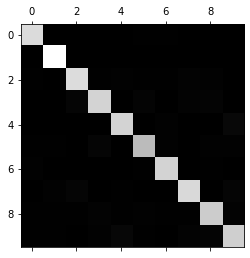

In [35]:
#Confusion matrix for Random Forest classifier
plt.matshow(confusion_matrix(y_test,y_test_pred), cmap=plt.cm.gray)
plt.show()


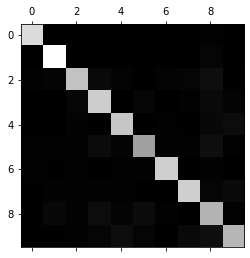

In [36]:
#Confusion matrix for SGD Classifier
plt.matshow(confusion_matrix(y_test,y_test_pred_1), cmap=plt.cm.gray)
plt.show()

In [39]:
#Accuracy of SGD classifier
cross_val_score(sgd_clf,X_test, y_test, scoring="accuracy")


array([0.8465, 0.8565, 0.877 , 0.8935, 0.9035])

In [38]:
#Accuracy of RandomForest Classifier
cross_val_score(forest_clf,X_test, y_test, scoring="accuracy")

array([0.9265, 0.926 , 0.947 , 0.9645, 0.9695])